In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import STL

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

**EDA**

In [2]:
#トレーニングデータのインポート
train=pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
#テストデータのインポート
test=pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/test.csv.zip")
#店舗情報のインポート
shop=pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/stores.csv")
#特徴情報のインポート
feature=pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/features.csv.zip")
#サンプルサブミッション
sample_submission=pd.read_csv("../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")

In [3]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [7]:
all_data=pd.concat([train,test])

In [8]:
# ３つのデータを結合(train,shop,feature)
all_data=pd.merge(all_data,shop,on="Store",how="left")
all_data=pd.merge(all_data,feature,on=["Store","Date"],how="left")

In [9]:
all_data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'],
      dtype='object')

In [10]:
#重複カラム削除
all_data.drop("IsHoliday_y",axis=1,inplace=True)
#カラム名変更
all_data.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [11]:
all_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [12]:
len(all_data["Store"].unique())
#→ショップは全部で45店舗

45

In [13]:
len(all_data["Dept"].unique())
#→Deptは全部で45店舗

81

In [14]:
all_data["Dept"].sort_values().unique()
#Deptは９９まであるものの、15,53,57など、歯抜けになっているものが存在し、全部で８１Deptとなっている。

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [15]:
# 店舗ごとのDeptの売上
pd.pivot_table(all_data,index="Store",columns="Dept",values="Weekly_Sales")
#→全ての店舗で全てのDeptが必ず売れているわけではなく、Dept９３や99は店によっては、販売されていないことが考えられる。

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


Text(0, 0.5, 'sales')

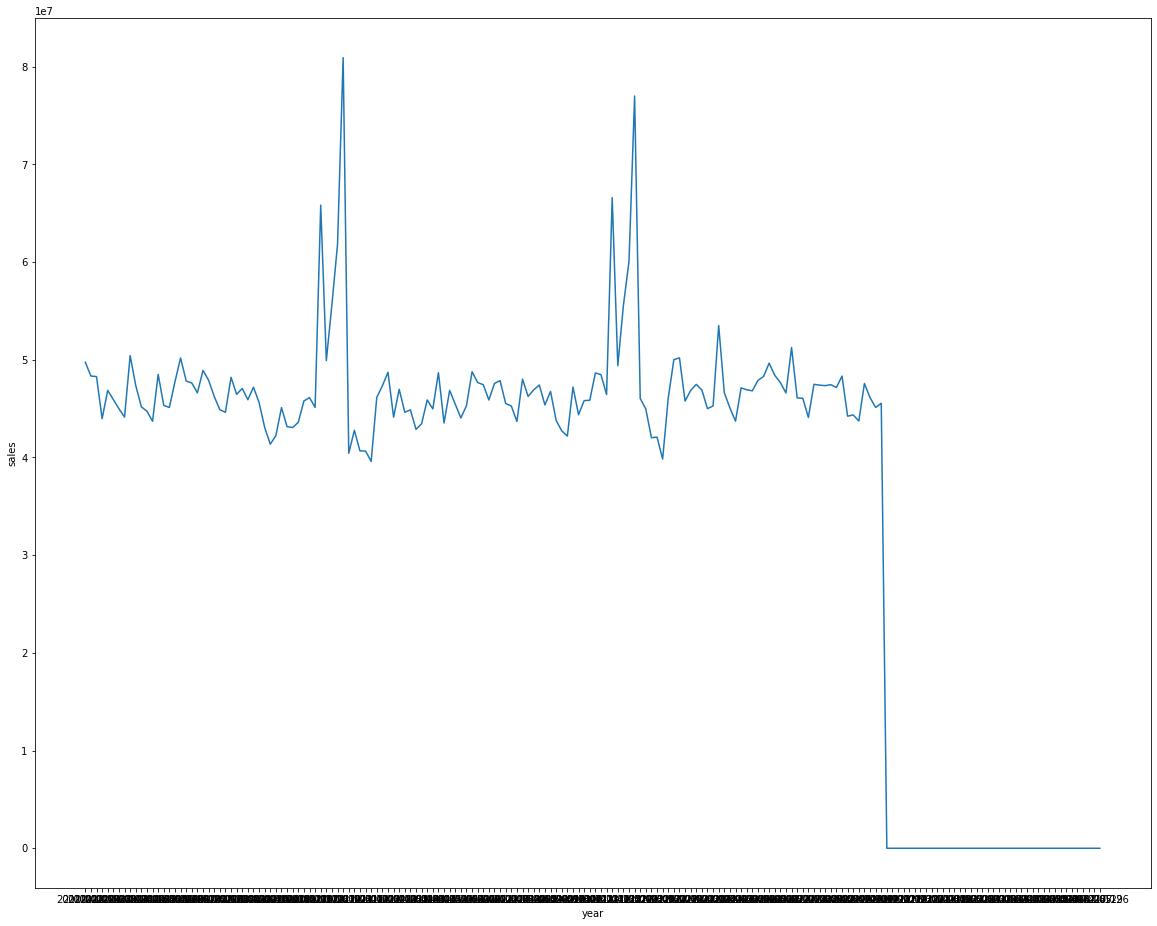

In [16]:
#全体の売上可視化
all_sales = all_data.groupby('Date')['Weekly_Sales'].sum()
plt.figure(figsize=(20,16))
plt.plot(all_sales)
plt.xlabel('year')
plt.ylabel('sales')
#毎年11月12月あたりで売上がかなり大きくなる傾向にある。

In [17]:
df_train=all_data[~(all_data["Weekly_Sales"].isnull())]
len(df_train)

421570

In [18]:
#週間売上
df_train[df_train["Weekly_Sales"]<0]
#売上がマイナスになっている日にちが複数存在する。これらのデータの取り扱いについては別途検討

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
846,1,6,2012-08-10,-139.65,False,A,151315,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908
2384,1,18,2012-05-04,-1.27,False,A,151315,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143
6048,1,47,2010-02-19,-863.00,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
6049,1,47,2010-03-12,-698.00,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106
6051,1,47,2010-10-08,-58.00,False,A,151315,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,B,118221,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992
419598,45,80,2010-02-19,-0.27,False,B,118221,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992
419603,45,80,2010-04-16,-1.61,False,B,118221,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899
419614,45,80,2010-07-02,-0.27,False,B,118221,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743


In [19]:
df_train.describe()["Weekly_Sales"]

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [20]:
# df_train[df_train["Weekly_Sales"]<0].groupby("Dept").count()
# df_train[(df_train["Weekly_Sales"]<0)&(df_train["Dept"]==18)].groupby("Store").count()
# df_train[df_train["Weekly_Sales"]<0].groupby("Store").count()
# plt.plot(df_train[(df_train["Dept"]==18)&(df_train["Store"]==35)]["Weekly_Sales"])
#売上がマイナスになっているものについては、傾向がないため、<0のものは0に置き換える
all_data["Weekly_Sales"]=all_data["Weekly_Sales"].apply(lambda x:1 if x<=0 else x)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

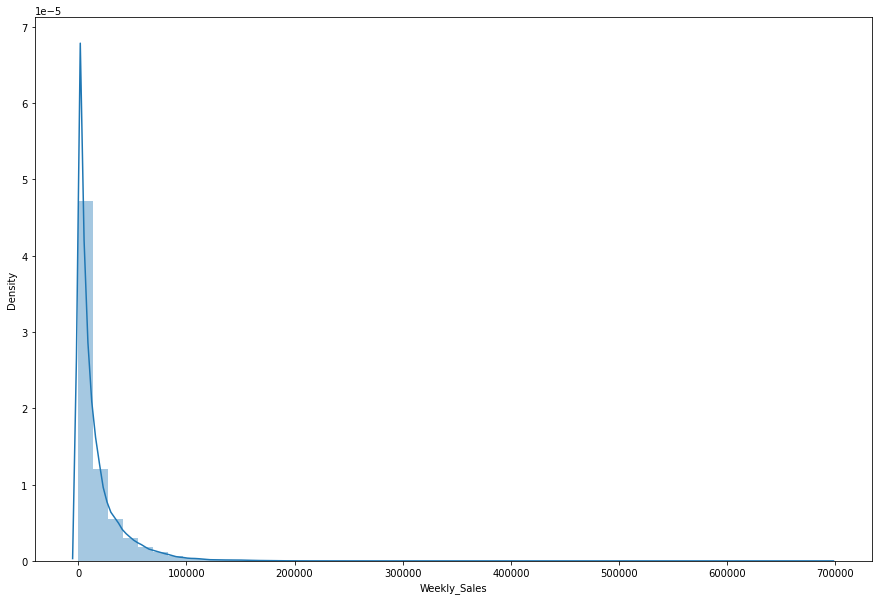

In [21]:
f,x = plt.subplots(figsize=(15,10))
sns.distplot(all_data[~(all_data["Weekly_Sales"].isnull())]["Weekly_Sales"])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

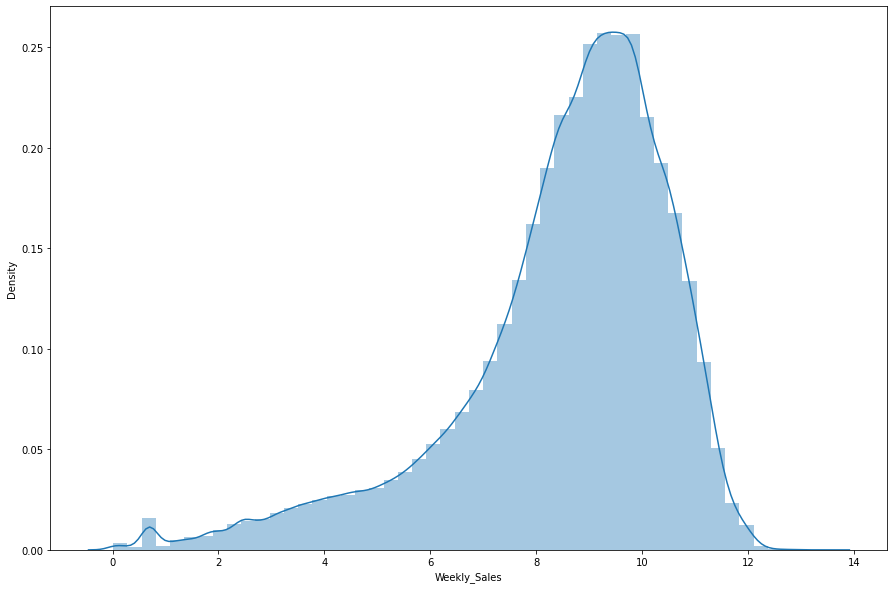

In [22]:
f,x = plt.subplots(figsize=(15,10))
sns.distplot(np.log1p(all_data[~(all_data["Weekly_Sales"].isnull())]["Weekly_Sales"]))

In [23]:
#対数変換したweekly_sales列を追加
all_data["Weekly_Sales_log"]=np.log1p(all_data[~(all_data["Weekly_Sales"].isnull())]["Weekly_Sales"])

In [24]:
#日付の型変更
#トレーニングデータ
all_data['Date_time'] = pd.to_datetime(all_data['Date'])
all_data['Month'] = all_data['Date_time'].dt.month
all_data['Year'] = all_data['Date_time'].dt.year
all_data['Week'] = all_data['Date_time'].dt.week
# #テストデータ
# test['Date'] = pd.to_datetime(test['Date'])
# test['Month'] = df_test['Date'].dt.month
# test['Year'] = df_test['Date'].dt.year
# test['Week'] = test['Date'].dt.week

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [25]:
df_train["Date"].sort_values()
#トレーニングデータの期間は、20100205から20121026の約2年8ヶ月

0         2010-02-05
277665    2010-02-05
277808    2010-02-05
277951    2010-02-05
278094    2010-02-05
             ...    
379648    2012-10-26
181170    2012-10-26
181313    2012-10-26
181599    2012-10-26
421569    2012-10-26
Name: Date, Length: 421570, dtype: object

In [26]:
#平日、休日のデータ量
df_train["IsHoliday"].value_counts()
#平日が約４０万日に対し、休日は約3万日

False    391909
True      29661
Name: IsHoliday, dtype: int64

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

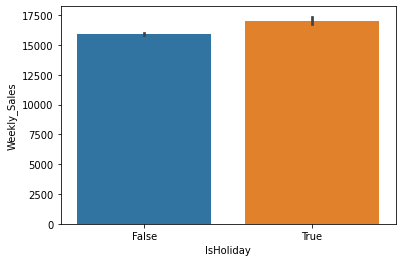

In [27]:
#平日、休日の売上の関係
sns.barplot(x="IsHoliday",y="Weekly_Sales",data=df_train)
#若干ではあるが、休日の方が売上が高くなっている。

In [28]:
all_data[all_data["IsHoliday"]==True]["Date"].unique()
#special holiday weekは、10日間存在している
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
# Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
# Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
# Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
#テストデータにThanksgivingとchristmasのデータが含まれている

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07', '2012-11-23', '2012-12-28',
       '2013-02-08'], dtype=object)

In [29]:
#特別休日の週数の確認
all_data[all_data["IsHoliday"]==True][["Date","Week"]].drop_duplicates().sort_values("Week")
#トレーニングデータ　内の週は変わりない
#週の何日目によっては売上が変わる場合もあるので注意
#週の先頭や終わりにイベントが来た場合、前後の週にも影響を及ぼしている可能性がある
#それぞれ曜日の確認
#Super Bowl:2010/02/12：金曜日、2011/02/11:金曜日、2012/02/10:金曜日、2013/02/08:金曜日
# Labor Day: 2010/09/09:木曜日、2011/09/09:金曜日、2012/09/07:金曜日、2013/09/06:金曜日
# Thanksgiving:2010/11/26:火曜日、2011/11/25:金曜日、2012/11/29:木曜日、2013/11/29:金曜日
# Christmas:2010/12/31:金曜日、2011/12/30:金曜日、2012/12/28:金曜日、2013/12/27:金曜日
#Super BowlとChristmasは曜日が一定であるため、前後の週への影響は大きくないと考えられる。
#一方で、Labor DayとThanksgivingは、曜日が違うので、前後の週への影響が多少考えれらる。

,Date,Week
1,2010-02-12,6
53,2011-02-11,6
105,2012-02-10,6
421584,2013-02-08,6
31,2010-09-10,36
83,2011-09-09,36
135,2012-09-07,36
42,2010-11-26,47
94,2011-11-25,47
421573,2012-11-23,47


In [30]:
df_train=all_data[~(all_data["Weekly_Sales"].isnull())]

<AxesSubplot:xlabel='Week'>

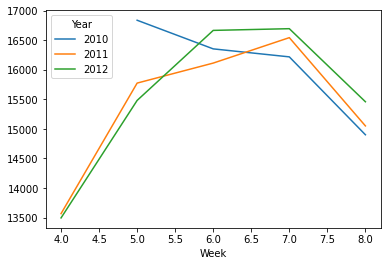

In [31]:
# Super Bowl:
df_leave_1=df_train[(df_train["Week"]>=4)&(df_train["Week"]<=8)]
pd.pivot_table(df_leave_1,values="Weekly_Sales",columns="Year",index="Week").plot()

<AxesSubplot:xlabel='Week'>

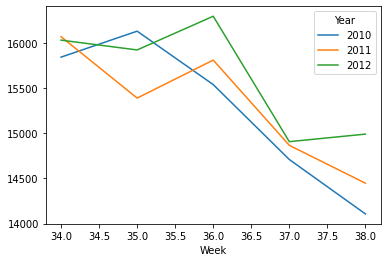

In [32]:
# Labor Day
df_leave_1=df_train[(df_train["Week"]>=34)&(df_train["Week"]<=38)]
pd.pivot_table(df_leave_1,values="Weekly_Sales",columns="Year",index="Week").plot()

<AxesSubplot:xlabel='Week'>

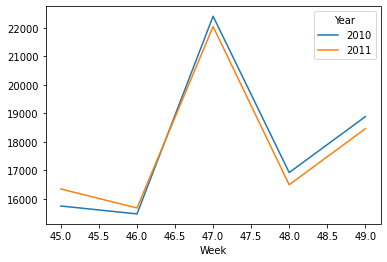

In [33]:
# Thanksgiving
df_leave_1=df_train[(df_train["Week"]>=45)&(df_train["Week"]<=49)]
pd.pivot_table(df_leave_1,values="Weekly_Sales",columns="Year",index="Week").plot()

<AxesSubplot:xlabel='Week'>

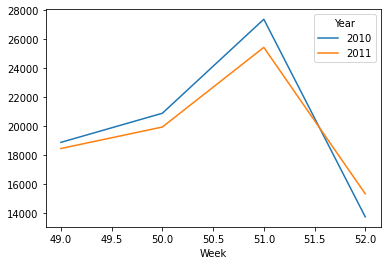

In [34]:
# Christmas
df_leave_1=df_train[(df_train["Week"]>=49)&(df_train["Week"]<=52)]
pd.pivot_table(df_leave_1,values="Weekly_Sales",columns="Year",index="Week").plot()

In [35]:
# 直前直後の週が直接売上に影響することはなさそう

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

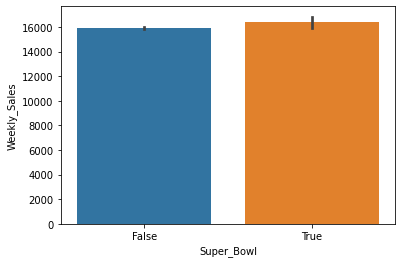

In [36]:
#４つのイベントと平日の売上を比較する
# Super Bowl:
df_train.loc[(df_train['Date'] == '2010-02-12')|(df_train['Date'] == '2011-02-11')|(df_train['Date'] == '2012-02-10'),"Super_Bowl"] = True
df_train.loc[(df_train['Date'] != '2010-02-12')&(df_train['Date'] != '2011-02-11')&(df_train['Date'] != '2012-02-10')&(df_train['IsHoliday']==False),'Super_Bowl'] = False
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df_train) 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

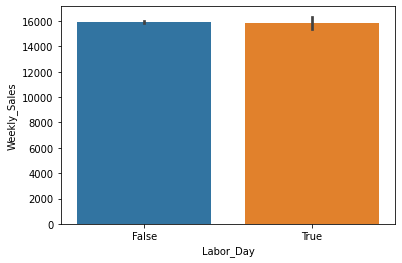

In [37]:
# Labor day
df_train.loc[(df_train['Date'] == '2010-09-10')|(df_train['Date'] == '2011-09-09')|(df_train['Date'] == '2012-09-07'),'Labor_Day'] = True
df_train.loc[(df_train['Date'] != '2010-09-10')&(df_train['Date'] != '2011-09-09')&(df_train['Date'] != '2012-09-07')&(df_train['IsHoliday']==False),'Labor_Day'] = False
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df_train) 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

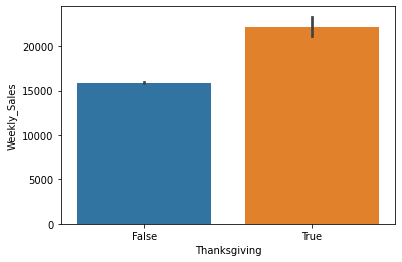

In [38]:
# Thanksgiving
df_train.loc[(df_train['Date'] == '2010-11-26')|(df_train['Date'] == '2011-11-25'),'Thanksgiving'] = True
df_train.loc[(df_train['Date'] != '2010-11-26')&(df_train['Date'] != '2011-11-25')&(df_train['IsHoliday']==False),'Thanksgiving'] = False
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df_train) 

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

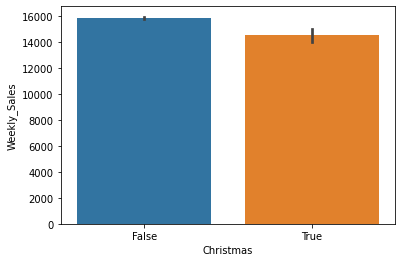

In [39]:
#Christmas
df_train.loc[(df_train['Date'] == '2010-12-31')|(df_train['Date'] == '2011-12-30'),'Christmas'] = True
df_train.loc[(df_train['Date'] != '2010-12-31')&(df_train['Date'] != '2011-12-30')&(df_train['IsHoliday']==False),'Christmas'] = False
sns.barplot(x="Christmas",y="Weekly_Sales",data=df_train)

In [40]:
#LabordayとChristmasは、平日平均より売上が下回ってる。
# また、Super BowlとThanksgivingはともに平日より売上が上回っている。
# 特にThanksgivingは大きい売上となっている。
# 一方、クリスマスのある12月は売上が大きくなっていたが、クリスマスの週に売上が大きくなるということではなさそう。

In [41]:
#type
df_train["Type"].unique()
# 店舗のタイプは全部で３つ存在する

array(['A', 'B', 'C'], dtype=object)

In [42]:
#ショップの構成
df_train[["Store","Type"]].drop_duplicates()["Type"].value_counts()
#店舗Aが22店舗、店舗Bが17店舗、店舗Cが6店舗という構成になっている

A    22
B    17
C     6
Name: Type, dtype: int64

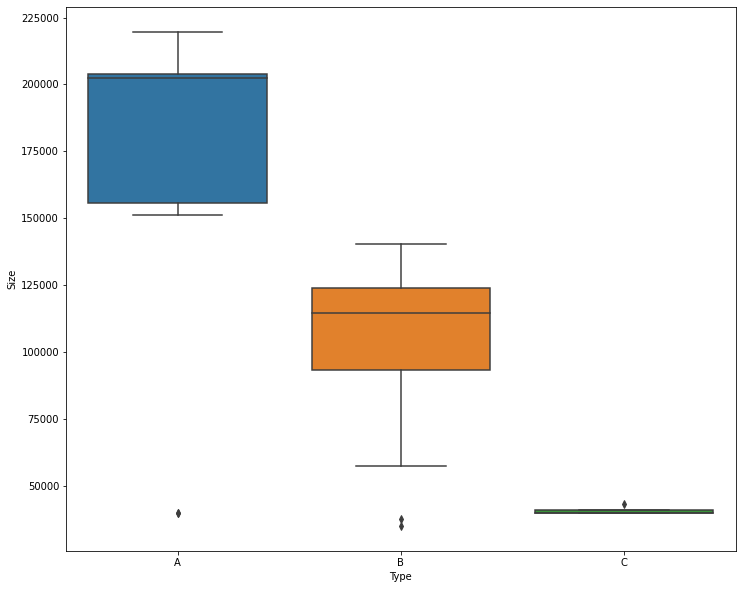

In [43]:
#ショップ別の規模
f,x = plt.subplots(figsize=(12,10))
fig = sns.boxplot(x='Type',y='Size',data=shop)
#A,B,Cの順でショップの規模は小さくなっていき、ショップ規模のかぶりはない。

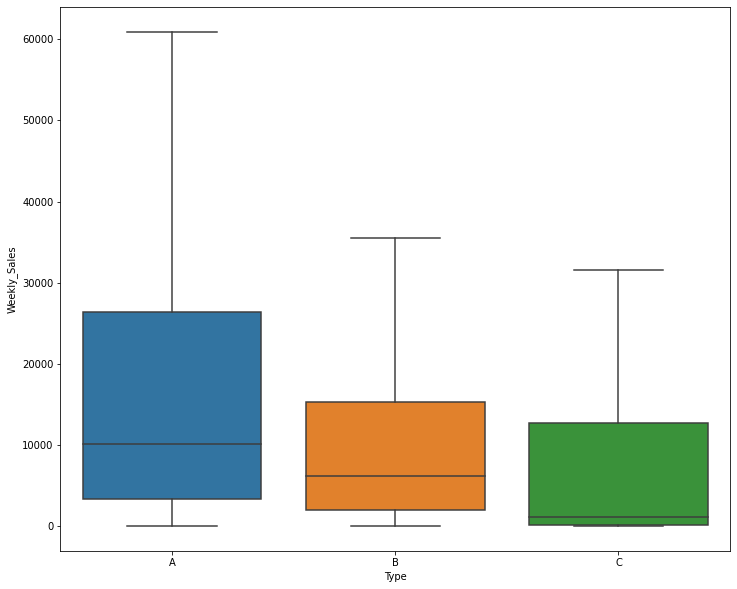

In [44]:
#ショップ別の週別売り上げ(外れ値非表示)
f,x = plt.subplots(figsize=(12,10))
fig = sns.boxplot(x='Type',y='Weekly_Sales',data=df_train,sym="")

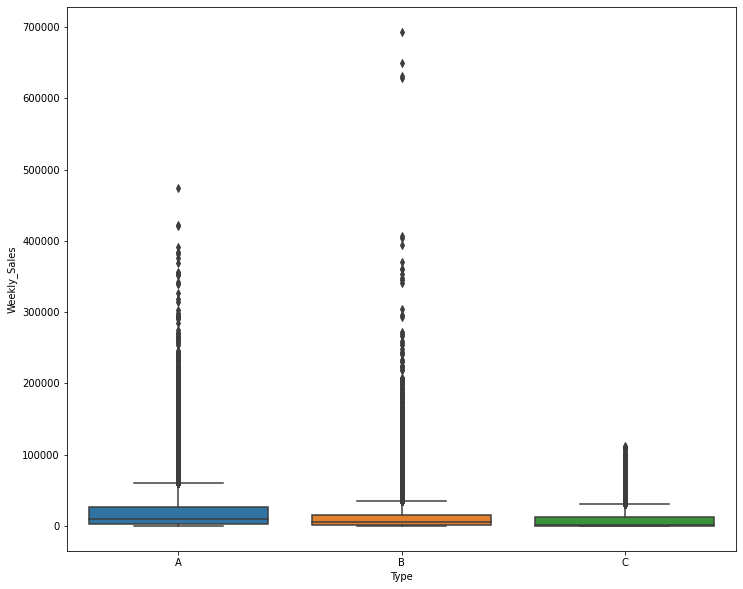

In [45]:
#ショップ別の週別売り上げ
f,x = plt.subplots(figsize=(12,10))
fig = sns.boxplot(x='Type',y='Weekly_Sales',data=df_train)
#基本的にショップの規模が大きいほど売り上げも大きくなる傾向がある。
#また、Bでは外れ値が一部 Aの外れ値よりも大きくなっている部分が存在する。

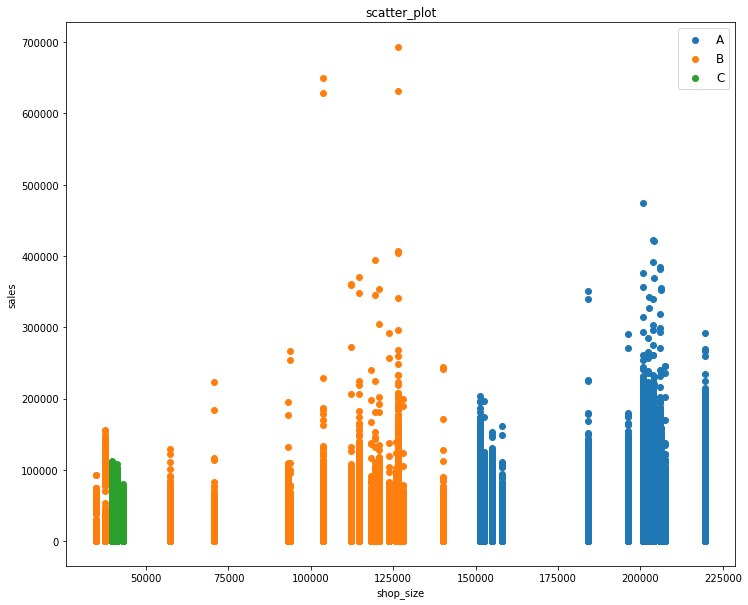

In [46]:
#ショップサイズと売り上げの関係
shop_types=shop['Type'].unique()
fig=plt.figure(figsize=(12,10))
x=fig.add_subplot()
for shop_type in shop_types:
    x1=df_train[df_train['Type']==shop_type]['Size']
    y1=df_train[df_train['Type']==shop_type]['Weekly_Sales']
    x.scatter(x1,y1,label=shop_type)

x.set_title('scatter_plot')
x.set_xlabel('shop_size')
x.set_ylabel('sales')
x.legend(fontsize=12)
plt.show()

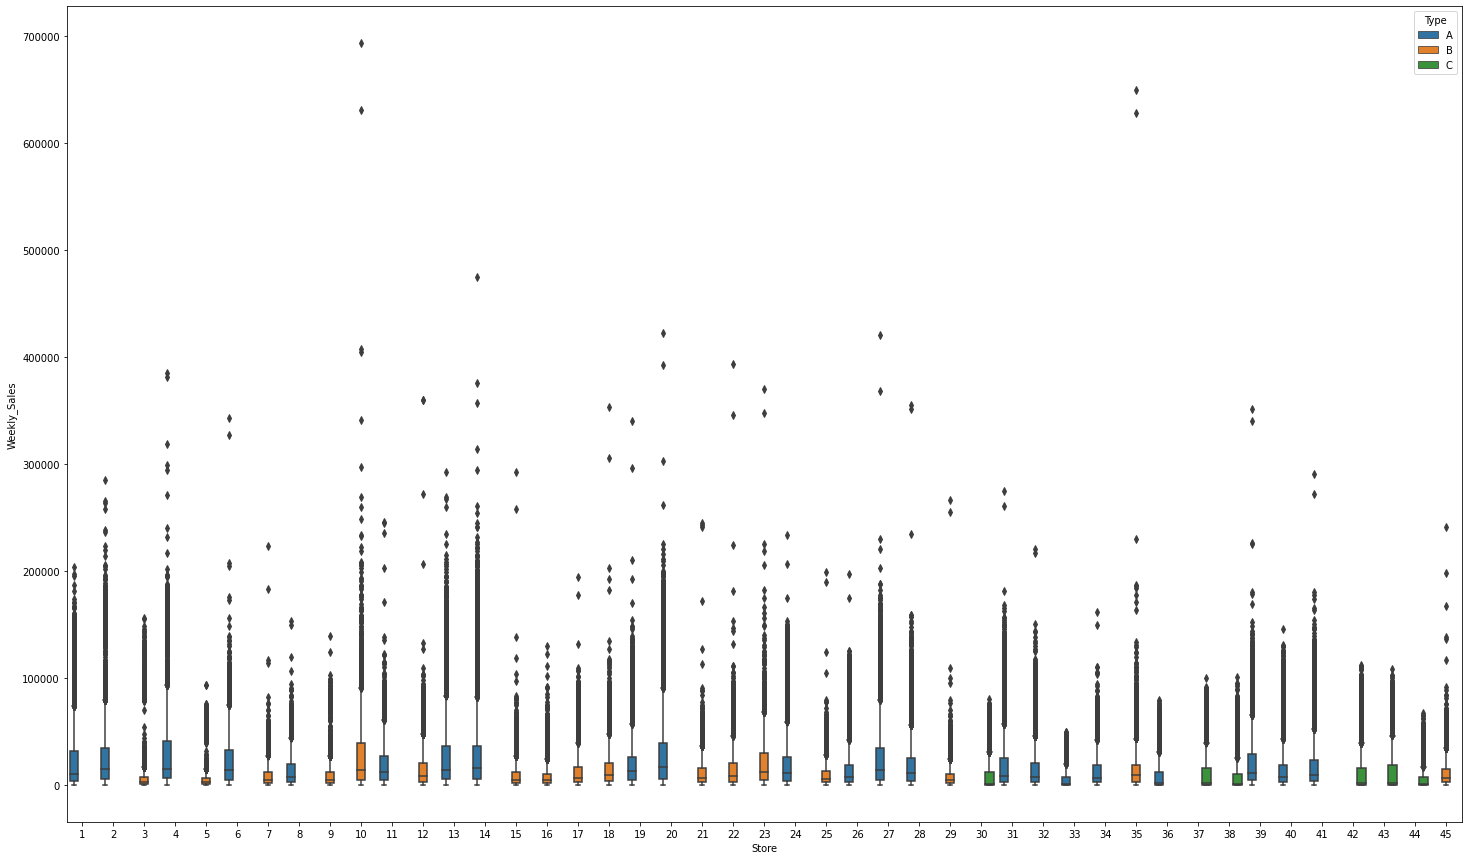

In [47]:
#ショップと週別売り上げの関係
f,x=plt.subplots(figsize=(25,15))
fig = sns.boxplot(x='Store',y='Weekly_Sales',data=df_train,hue='Type')

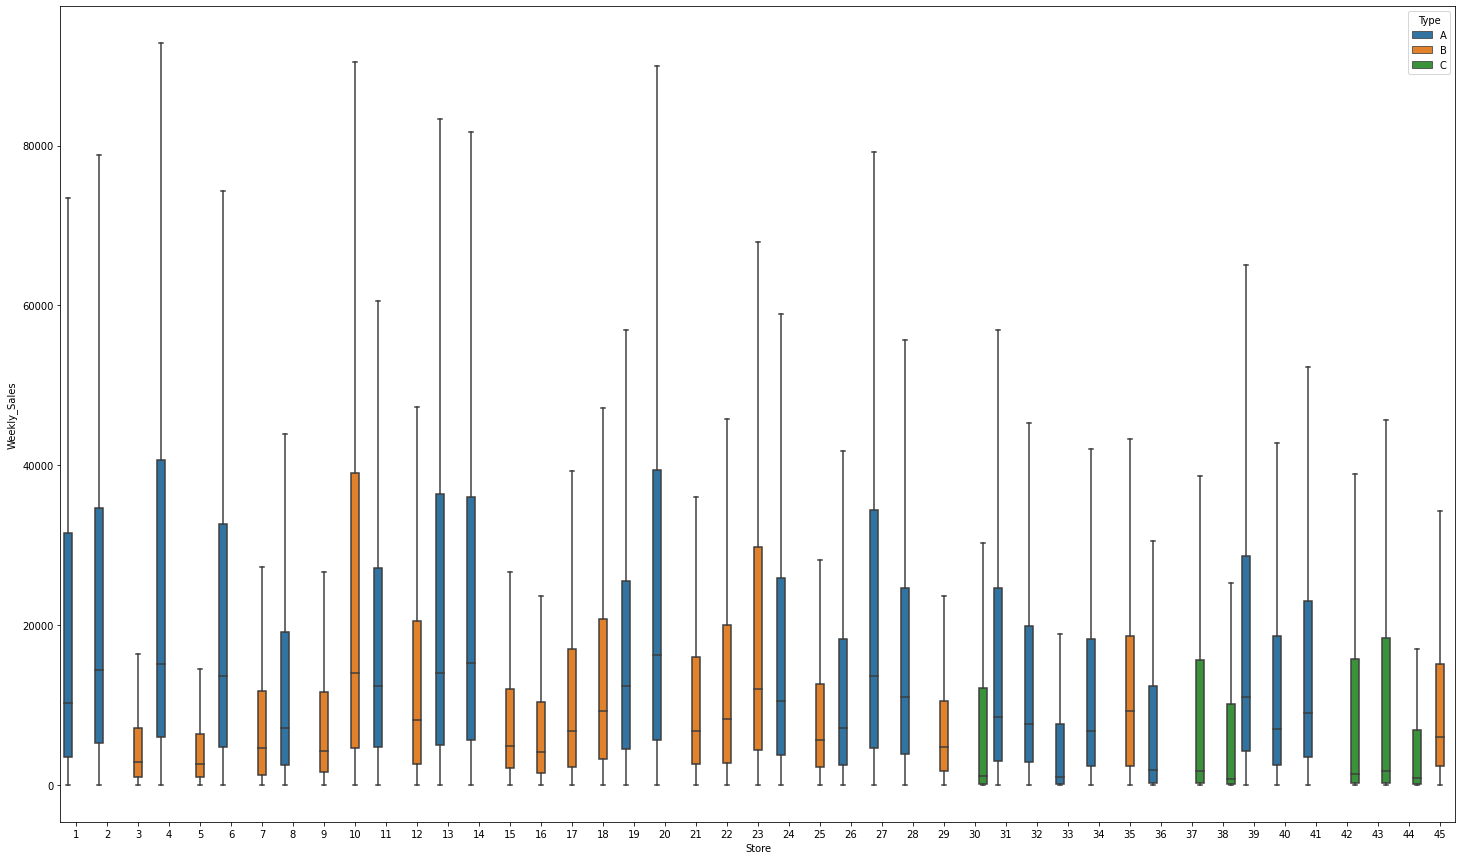

In [48]:
#ショップと週別売り上げの関係
f,x=plt.subplots(figsize=(25,15))
fig = sns.boxplot(x='Store',y='Weekly_Sales',data=df_train,hue='Type',showfliers=False)

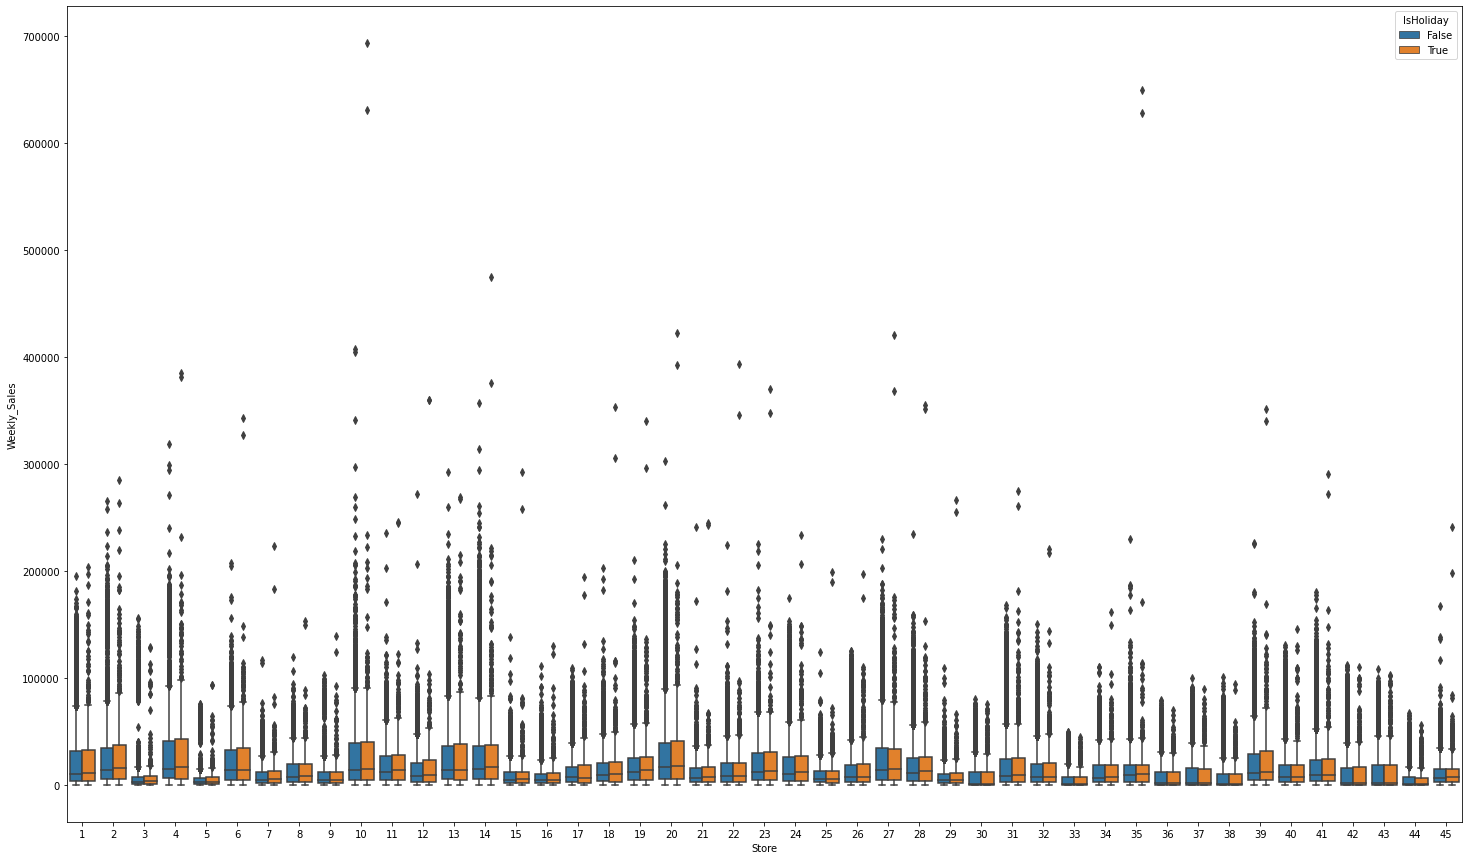

In [49]:
#ショップと週別売り上げの関係(休祝日情報追加)
f,x=plt.subplots(figsize=(25,15))
fig = sns.boxplot(x='Store',y='Weekly_Sales',data=df_train,hue='IsHoliday')

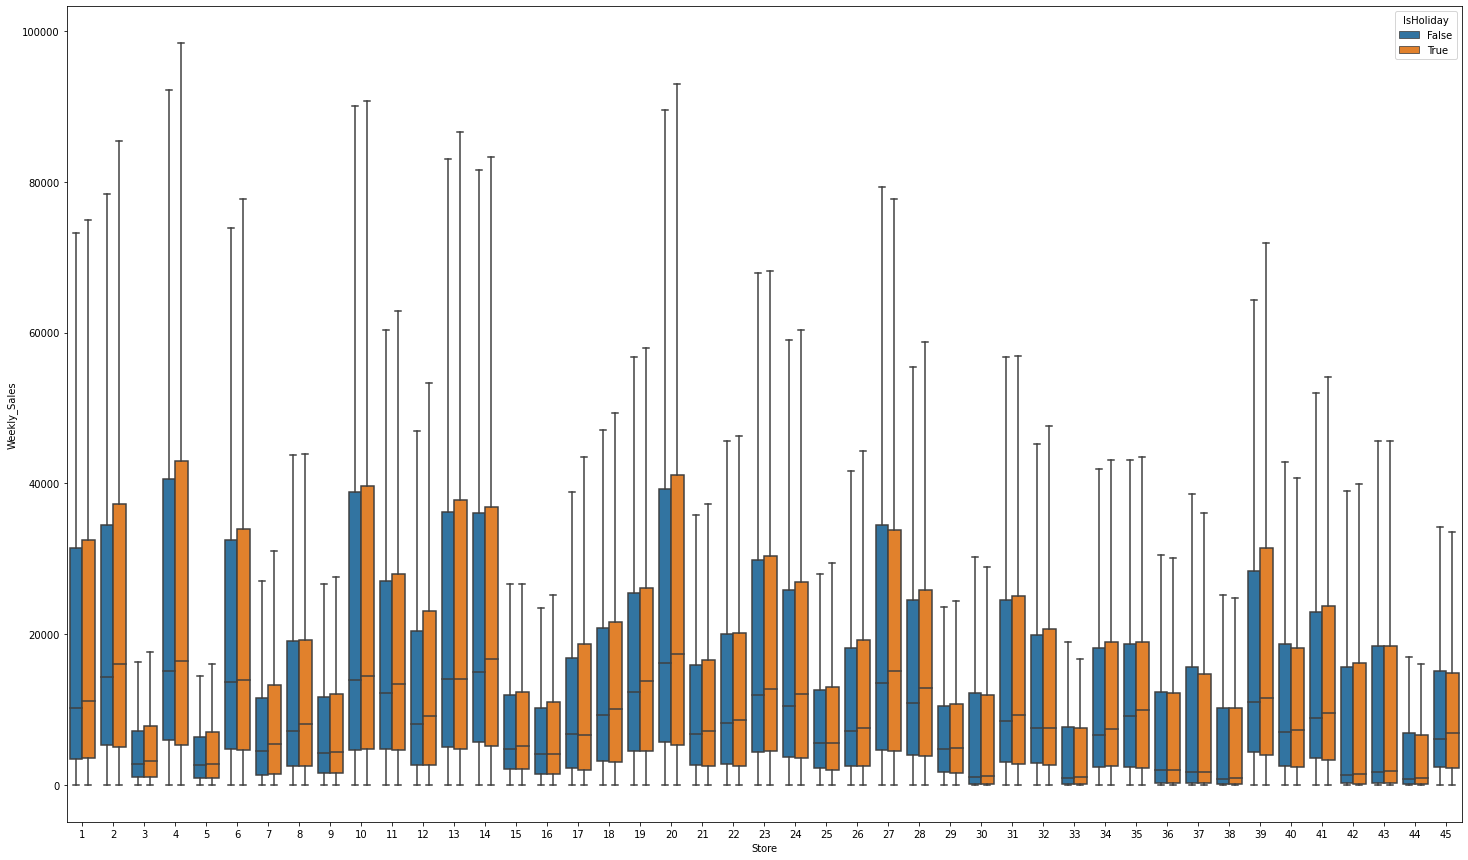

In [50]:
#ショップと週別売り上げの関係(休祝日情報追加)
f,x=plt.subplots(figsize=(25,15))
fig = sns.boxplot(x='Store',y='Weekly_Sales',data=df_train,hue='IsHoliday',showfliers=False)

#休日だからといって必ず平日より高くなることはない。

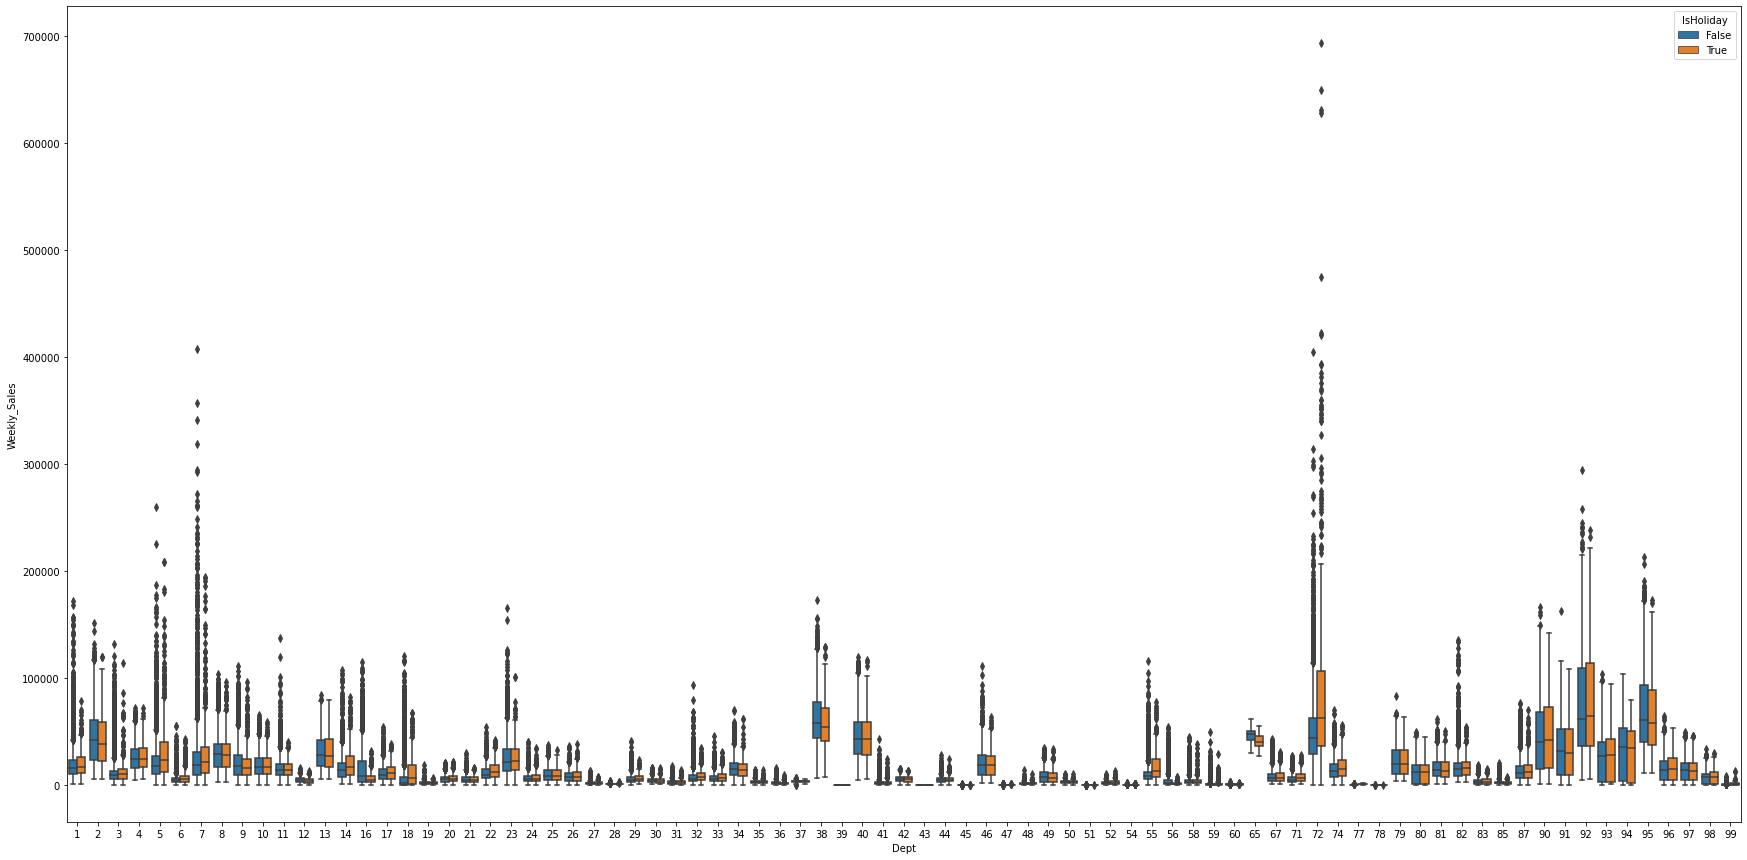

In [51]:
#deptと週別売り上げの関係性可視化
f,x=plt.subplots(figsize=(30,15))
fig = sns.boxplot(x='Dept',y='Weekly_Sales',data=df_train,hue='IsHoliday')

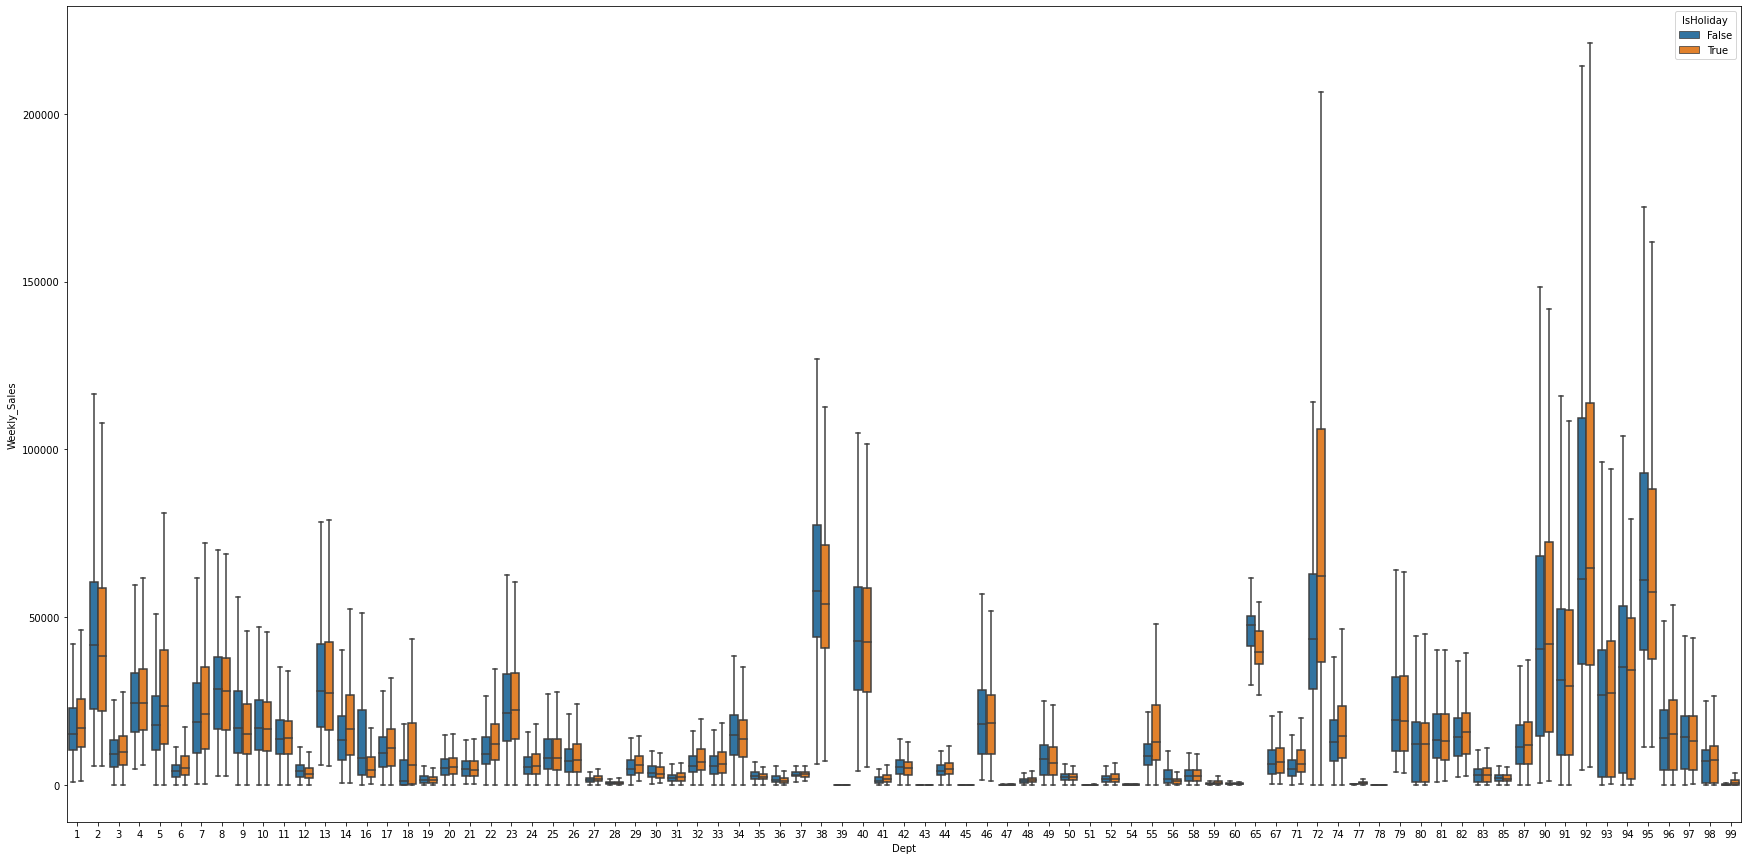

In [52]:
#deptと週別売り上げの関係性可視化
f,x=plt.subplots(figsize=(30,15))
fig = sns.boxplot(x='Dept',y='Weekly_Sales',data=df_train,hue='IsHoliday',showfliers=False)

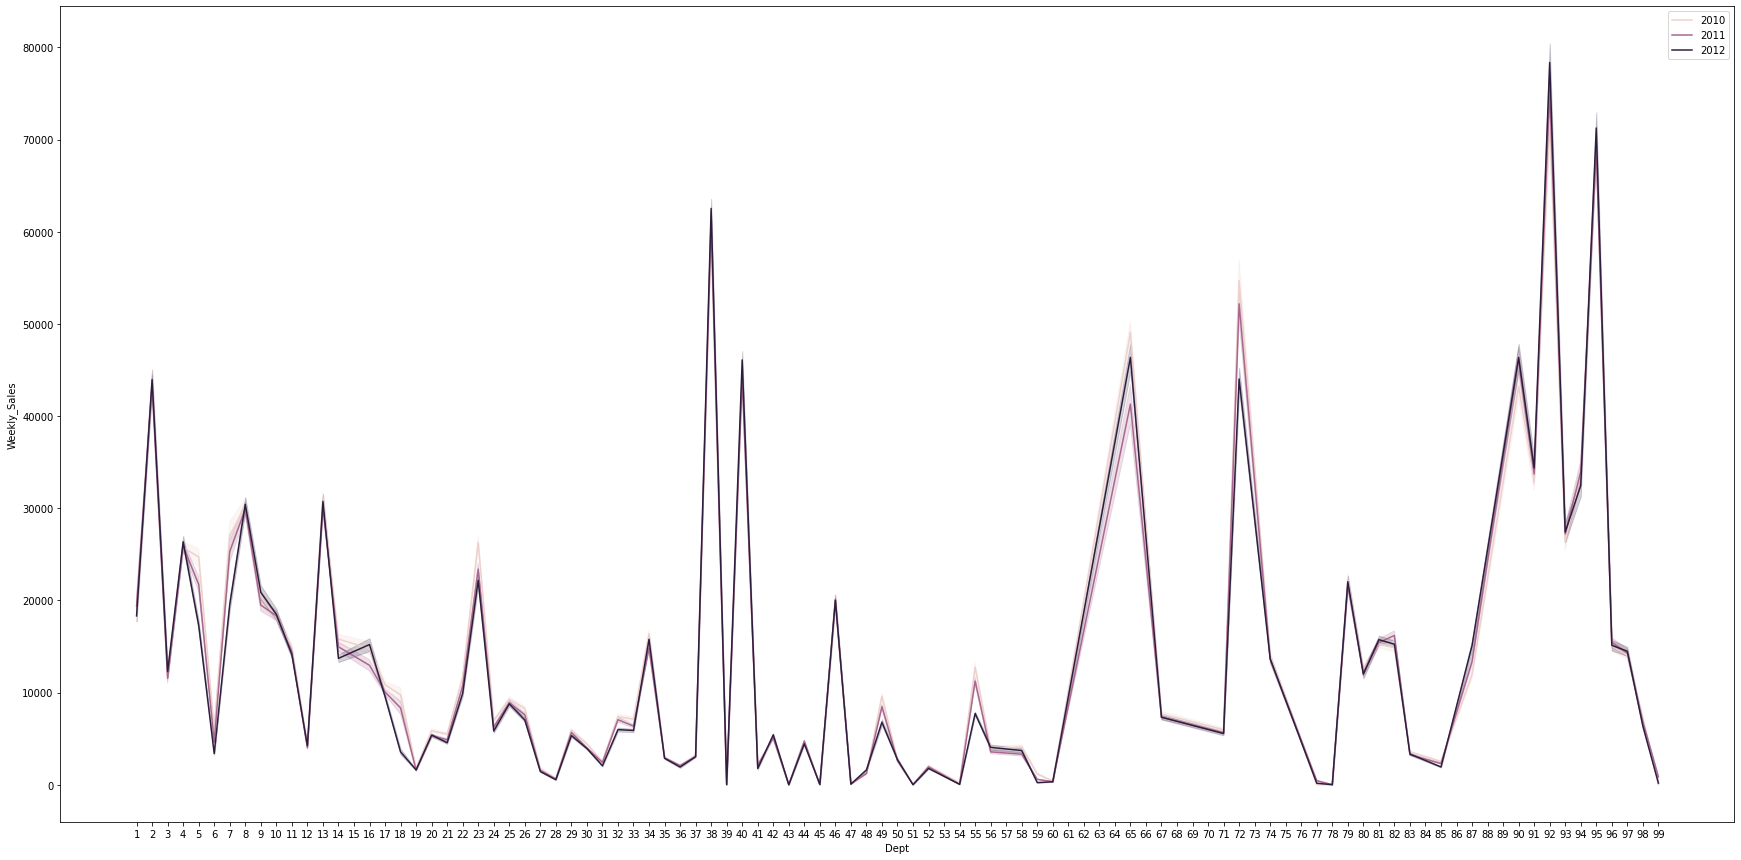

In [53]:
#deptごとのweekly_salesを年ごとに表記
f,x=plt.subplots(figsize=(30,15))
fig = sns.lineplot(x='Dept',y='Weekly_Sales',data=df_train,hue='Year')
plt.xticks(np.arange(1, 100))
plt.legend()
plt.show()
#deptが65と72で年間での動きが大きいdeptが存在する。
#deptによって売上に大きな違いがあるため、売上予測にはdeptが大きく影響すると考えられる。

Text(0, 0.5, 'Weekly_Sales_mean')

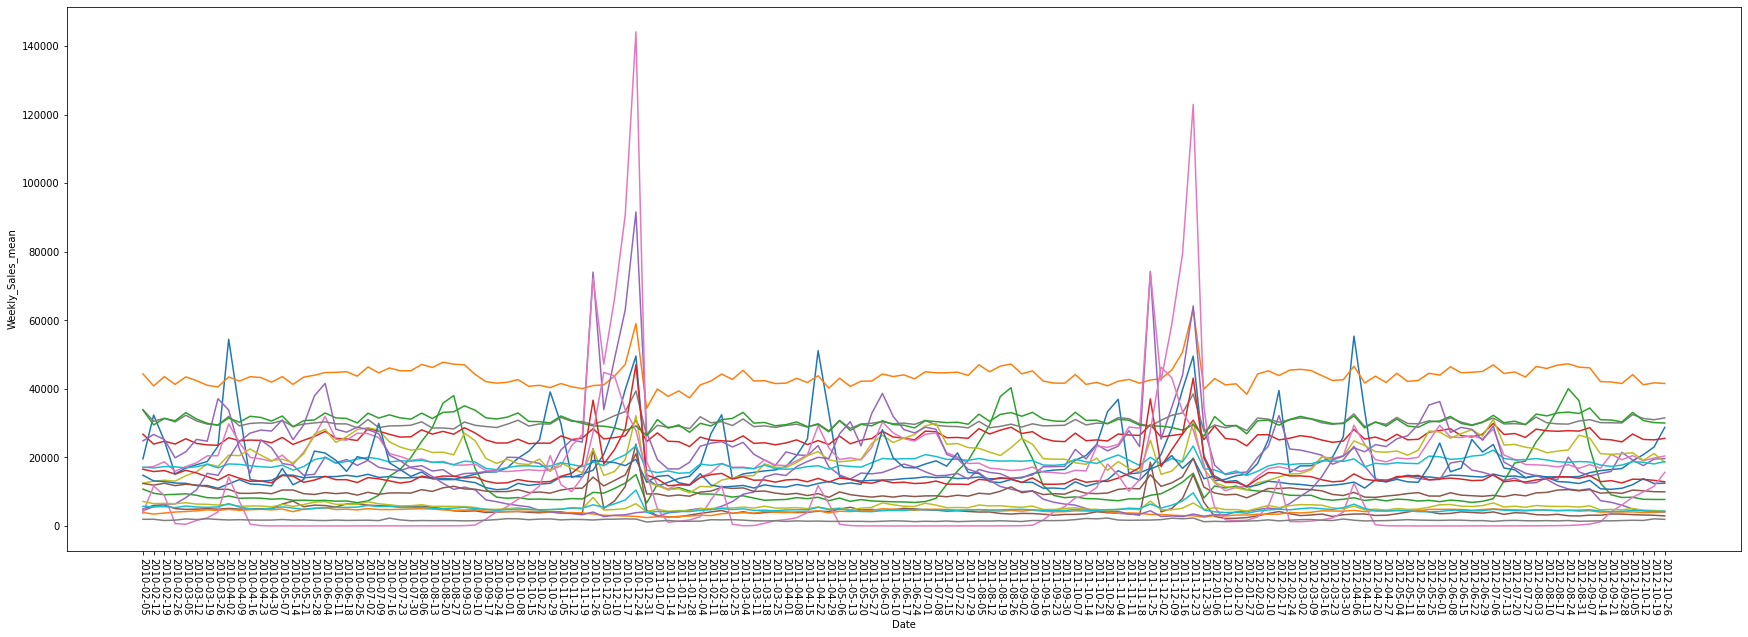

In [54]:
#deptごとの年間平均売上の可視化
dept_mean=df_train.groupby(["Dept","Date"]).mean().reset_index()[["Dept","Date","Weekly_Sales"]]
dept=dept_mean["Dept"].unique()

fig,x=plt.subplots(figsize=(30,10))
plt.xticks(rotation=-90)
for i in dept[:20]:
    data=dept_mean[dept_mean["Dept"]==i]
    x.plot(data["Date"],data["Weekly_Sales"])

x.set_xlabel("Date")
x.set_ylabel("Weekly_Sales_mean")

#売上にはdeptごとに影響があり、クリスマス等の影響をダイレクトに受けているものもあれば、それほど大きな影響を受けていない店舗も存在する。
#クリスマス等の影響度合い別のモデル作成は有効にきく可能性がある。

<AxesSubplot:xlabel='Month'>

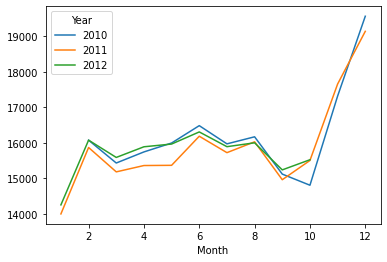

In [55]:
# 月別売上（年別）
pd.pivot_table(df_train, values = "Weekly_Sales", columns = "Year", index = "Month").plot()
# 2011年は1年を通して１番低い傾向にある。

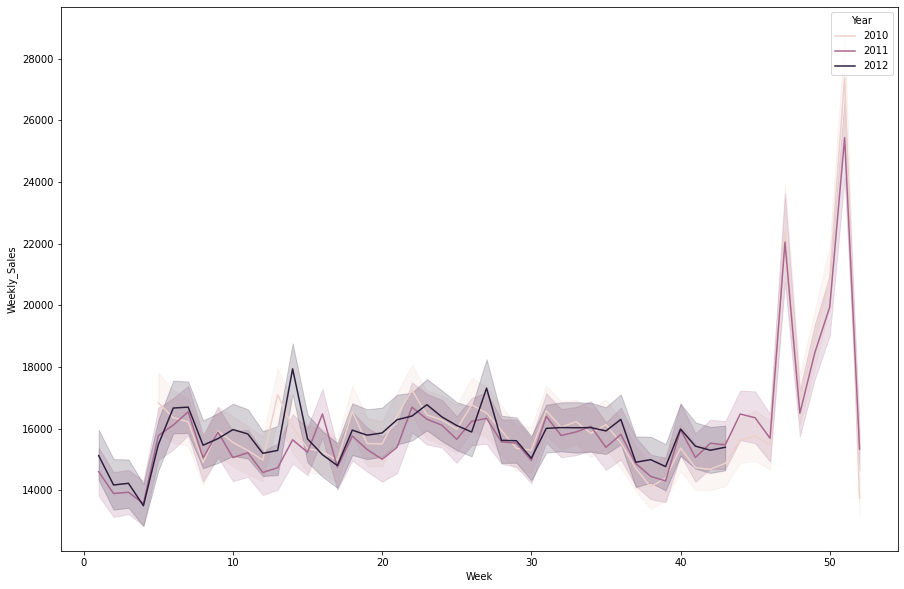

In [56]:
#週別週間売上（年ごと）
plt.figure(figsize=(15,10))
sns.lineplot(data=df_train,x='Week',y='Weekly_Sales',hue='Year',linewidth=1.5)
plt.show()
#12月の売上は52週のクリスマスではなく、１週間前の51週に最も売上が高くなっている。

In [57]:
#markdown
df_train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4"]].isna().sum()
#markdownには空欄がかなり多いため、空欄を０に置き換える
df_train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4"]]=df_train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4"]].fillna(0)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [58]:
#markdownの空欄を穴埋めできたか確認
df_train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4"]].isna().sum()

MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
dtype: int64

<AxesSubplot:xlabel='Fuel_Price'>

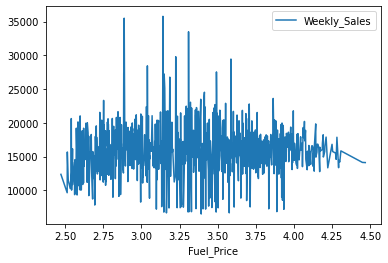

In [59]:
#fuel_price
pd.pivot_table(df_train, values = "Weekly_Sales", index= "Fuel_Price").plot()


<AxesSubplot:xlabel='Temperature'>

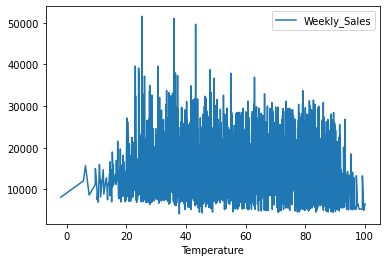

In [60]:
#tempreture
pd.pivot_table(df_train, values = "Weekly_Sales", index= "Temperature").plot()

<AxesSubplot:xlabel='CPI'>

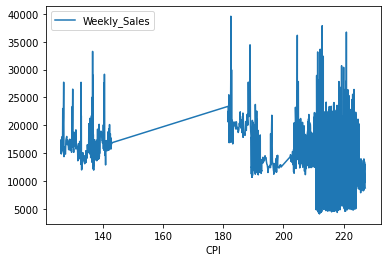

In [61]:
#CPI
pd.pivot_table(df_train, values = "Weekly_Sales", index= "CPI").plot()

<AxesSubplot:xlabel='Unemployment'>

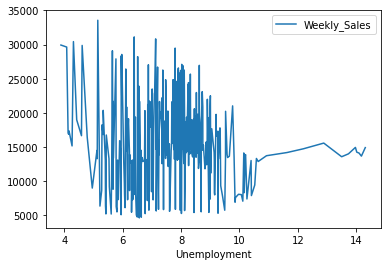

In [62]:
#unenployment
pd.pivot_table(df_train, values = "Weekly_Sales", index= "Unemployment").plot()

In [63]:
# Super Bowl:
all_data.loc[(all_data['Date'] == '2010-02-12')|(all_data['Date'] == '2011-02-11')|(all_data['Date'] == '2012-02-10')|(all_data['Date'] == '2013-02-08'),"Super_Bowl"] = True
all_data.loc[(all_data['Date'] != '2010-02-12')&(all_data['Date'] != '2011-02-11')&(all_data['Date'] != '2012-02-10')&(all_data['Date'] != '2013-02-08')&(all_data['IsHoliday']==False),'Super_Bowl'] = False
# Labor day
all_data.loc[(all_data['Date'] == '2010-09-10')|(all_data['Date'] == '2011-09-09')|(all_data['Date'] == '2012-09-07'),'Labor_Day'] = True
all_data.loc[(all_data['Date'] != '2010-09-10')&(all_data['Date'] != '2011-09-09')&(all_data['Date'] != '2012-09-07')&(all_data['IsHoliday']==False),'Labor_Day'] = False
# Thanksgiving
all_data.loc[(all_data['Date'] == '2010-11-26')|(all_data['Date'] == '2011-11-25')|(all_data['Date'] == '2012-11-29'),'Thanksgiving'] = True
all_data.loc[(all_data['Date'] != '2010-11-26')&(all_data['Date'] != '2011-11-25')&(all_data['Date'] != '2012-11-29')&(all_data['IsHoliday']==False),'Thanksgiving'] = False
#Christmas
all_data.loc[(all_data['Date'] == '2010-12-31')|(all_data['Date'] == '2011-12-30')|(all_data['Date'] == '2012-12-28'),'Christmas'] = True
all_data.loc[(all_data['Date'] != '2010-12-31')&(all_data['Date'] != '2011-12-30')&(all_data['Date'] != '2012-12-28')&(all_data['IsHoliday']==False),'Christmas'] = False

In [64]:
#encoding
#True,FalseやA ,B,Cを数値化
all_data["Super_Bowl"]=all_data["Super_Bowl"].apply(lambda x:1 if x==True else 0)
all_data["Labor_Day"]=all_data["Labor_Day"].apply(lambda x:1 if x==True else 0)
all_data["Thanksgiving"]=all_data["Thanksgiving"].apply(lambda x:1 if x==True else 0)
all_data["Christmas"]=all_data["Christmas"].apply(lambda x:1 if x==True else 0)
all_data["IsHoliday"]=all_data["IsHoliday"].apply(lambda x:1 if x==True else 0)
all_data["Type"]=all_data["Type"].apply(lambda x:1 if x=="A" else(2 if x=="B" else 3))

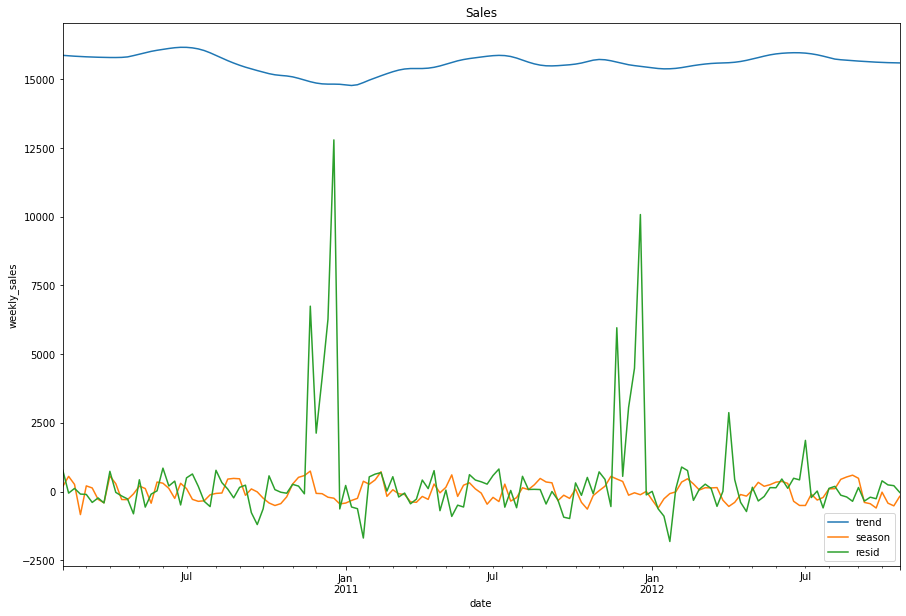

In [65]:
#週別の売上を季節成分、トレンド成分、残差に分解
sales=df_train.groupby('Date_time')['Weekly_Sales'].mean()
stl=STL(sales,period=12,robust=True)
stl_series=stl.fit()

plt.figure(figsize=(15,10))
stl_series.trend.plot()
stl_series.seasonal.plot()
stl_series.resid.plot()
plt.title("Sales")
plt.ylabel("weekly_sales")
plt.xlabel("date")
plt.legend()
plt.show()
#残差の成分が、11月12月で非常に大きくなっている

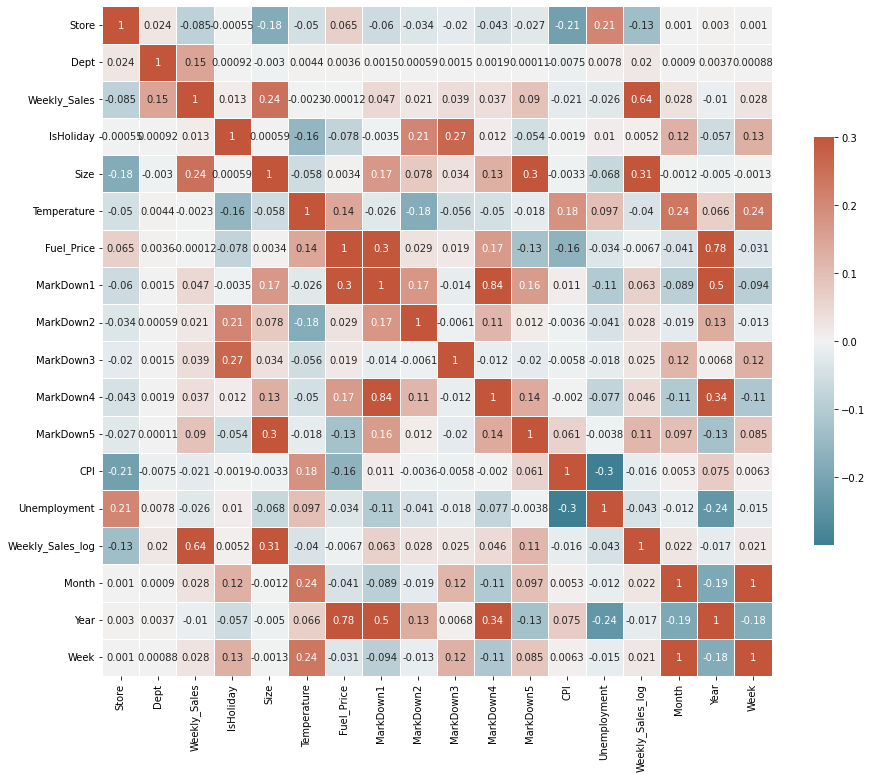

In [66]:
#混合行列
corr = df_train.corr()
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [67]:
#create feature
#①月の何週目
import calendar
#月の何週目かを返す関数
def get_nth_week(year,month,day,firstweekday=0):
    first_dow = calendar.monthrange(year,month)[0]
    offset = (first_dow-firstweekday)%7
    return  (day+offset-1)//7+1  

all_data["month_week"]=all_data["Date_time"].apply(lambda x:get_nth_week(x.year,x.month,x.day))

In [68]:
# # #②昨年の売上を追加
# last_data=all_data[["Store","Dept",'Year',"Week","Weekly_Sales"]].sort_values(["Store","Dept","Year","Week"]).rename(columns={"Weekly_Sales":"Weekly_Sales_1year_before"})
# last_data["year-1"]=last_data["Year"]+1
# last_data=last_data.drop(["Year"],axis=1)
# all_data=pd.merge(all_data,last_data,left_on=["Store","Dept","Year","Week"],right_on=["Store","Dept","year-1","Week"],how="left").drop(["year-1"],axis=1)
# # all_data["Weekly_Sales_log_1year_before"]=all_data["Weekly_Sales_log_1year_before"].fillna(0)
# all_data["Weekly_Sales_1year_before"]=all_data["Weekly_Sales_1year_before"].fillna(all_data["Weekly_Sales"])

In [69]:
#### #③１週間前の売上を追加
# last_data=all_data[["Store","Dept",'Year',"Week","Weekly_Sales"]].sort_values(["Store","Dept","Year","Week"]).rename(columns={"Weekly_Sales":"Weekly_Sales_1week_before"})
# last_data["week-1"]=last_data["Week"]+1
# last_data=last_data.drop(["Week"],axis=1)
# all_data=pd.merge(all_data,last_data,left_on=["Store","Dept","Year","Week"],right_on=["Store","Dept","Year","week-1"],how="left").drop(["week-1"],axis=1)
# all_data["Weekly_Sales_1week_before"]=all_data["Weekly_Sales_1week_before"].fillna(0)

In [70]:
# #④2週間前の売上を追加
# last_data=all_data[["Store","Dept",'Year',"Week","Weekly_Sales"]].sort_values(["Store","Dept","Year","Week"]).rename(columns={"Weekly_Sales":"Weekly_Sales_2week_before"})
# last_data["week-2"]=last_data["Week"]+2
# last_data=last_data.drop(["Week"],axis=1)
# all_data=pd.merge(all_data,last_data,left_on=["Store","Dept","Year","Week"],right_on=["Store","Dept","Year","week-2"],how="left").drop(["week-2"],axis=1)
# all_data["Weekly_Sales_2week_before"]=all_data["Weekly_Sales_2week_before"].fillna(0)

In [71]:
# #⑤4週間前の売上を追加
# last_data=all_data[["Store","Dept",'Year',"Week","Weekly_Sales"]].sort_values(["Store","Dept","Year","Week"]).rename(columns={"Weekly_Sales":"Weekly_Sales_4week_before"})
# last_data["week-4"]=last_data["Week"]+4
# last_data=last_data.drop(["Week"],axis=1)
# all_data=pd.merge(all_data,last_data,left_on=["Store","Dept","Year","Week"],right_on=["Store","Dept","Year","week-4"],how="left").drop(["week-4"],axis=1)
# all_data["Weekly_Sales_4week_before"]=all_data["Weekly_Sales_4week_before"].fillna(0)

In [72]:
all_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = all_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
# df_all = all_data.drop(columns=["Date", "CPI", "Fuel_Price", "Unemployment", "Temperature","Weekly_Sales_log","Date_time"])
# df_all_train_target = df_all[~(df_all["Weekly_Sales"].isnull())]["Weekly_Sales"]
# df_all_train=df_all[~(df_all["Weekly_Sales"].isnull())].drop("Weekly_Sales",axis=1)
df_all = all_data.drop(columns=["Date", "CPI", "Fuel_Price", "Unemployment", "Temperature","Weekly_Sales","Date_time"])
df_all_train_target = df_all[~(df_all["Weekly_Sales_log"].isnull())]["Weekly_Sales_log"]
df_all_train=df_all[~(df_all["Weekly_Sales_log"].isnull())].drop("Weekly_Sales_log",axis=1)

create_model

In [73]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    df_all_train, df_all_train_target, test_size=0.3, random_state=42)

decision tree

In [74]:
tree = DecisionTreeRegressor(random_state=0)

In [75]:
%%time
tree.fit(train_inputs, train_targets)

CPU times: user 2.8 s, sys: 52.7 ms, total: 2.85 s
Wall time: 2.85 s


DecisionTreeRegressor(random_state=0)

In [76]:
tree_train_preds = tree.predict(train_inputs)
tree_train_rmse = mean_squared_error(train_targets, tree_train_preds, squared=False)
tree_val_preds = tree.predict(val_inputs)
tree_val_rmse = mean_squared_error(val_targets, tree_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 4.624463344515659e-18, Validation RMSE: 0.4688444901267535


Decision Tree feature importance

In [77]:
tree_importances = tree.feature_importances_
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

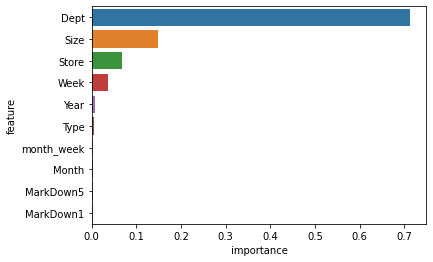

In [78]:
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature')

Random Forest


In [79]:
rf = RandomForestRegressor(random_state=0, n_estimators=10)

In [80]:
%%time
rf.fit(train_inputs, train_targets)

CPU times: user 18.4 s, sys: 172 ms, total: 18.6 s
Wall time: 18.6 s


RandomForestRegressor(n_estimators=10, random_state=0)

In [81]:
rf_train_preds = rf.predict(train_inputs)
rf_train_rmse = mean_squared_error(train_targets, rf_train_preds, squared=False)
rf_val_preds = rf.predict(val_inputs)
rf_val_rmse = mean_squared_error(val_targets, rf_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf_train_rmse, rf_val_rmse))


Train RMSE: 0.1588271834760573, Validation RMSE: 0.37158369342459346


Hyperparameter Tuning


In [82]:
def test_params(**params):
    model = RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=15, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [83]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(15,10))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [84]:
test_params()

(0.15017254032448948, 0.36463695444271516)

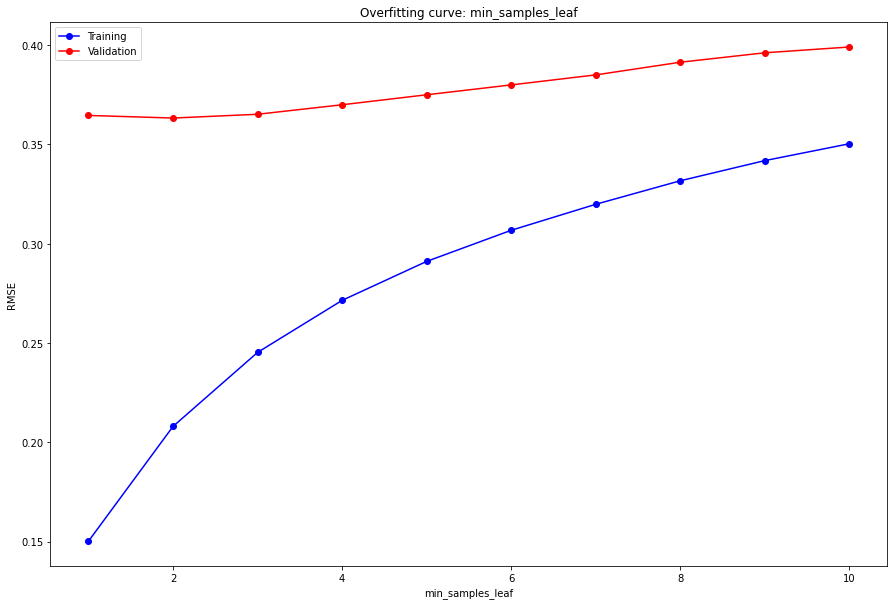

In [85]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5,6,7,8,9,10])

In [86]:
test_params(min_samples_leaf = 10)

(0.3503720191657981, 0.3991070297534616)

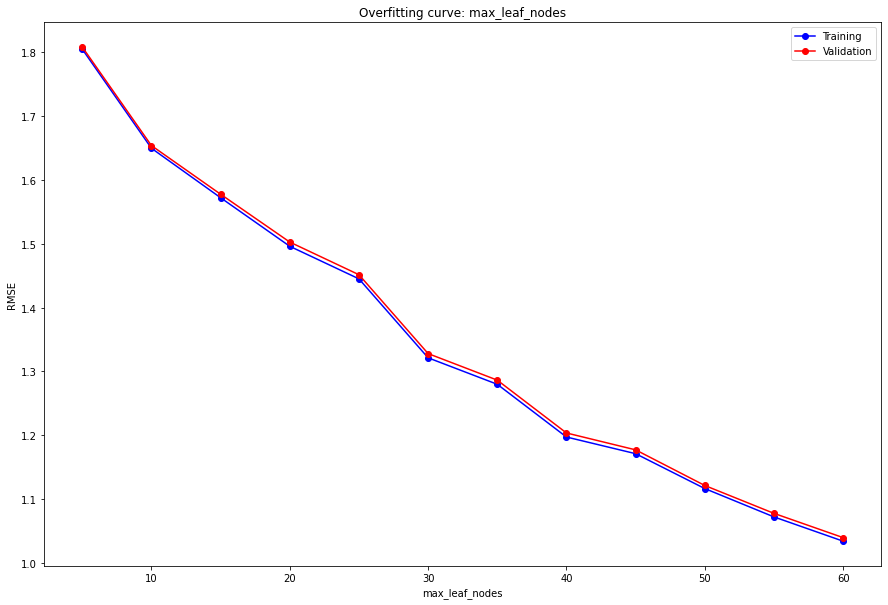

In [87]:
test_param_and_plot('max_leaf_nodes', [5,10,15,20, 25, 30, 35, 40, 45 ,50 ,55 ,60])


In [88]:
test_params(max_leaf_nodes = 30)

(1.3213853270854077, 1.3280185548502714)

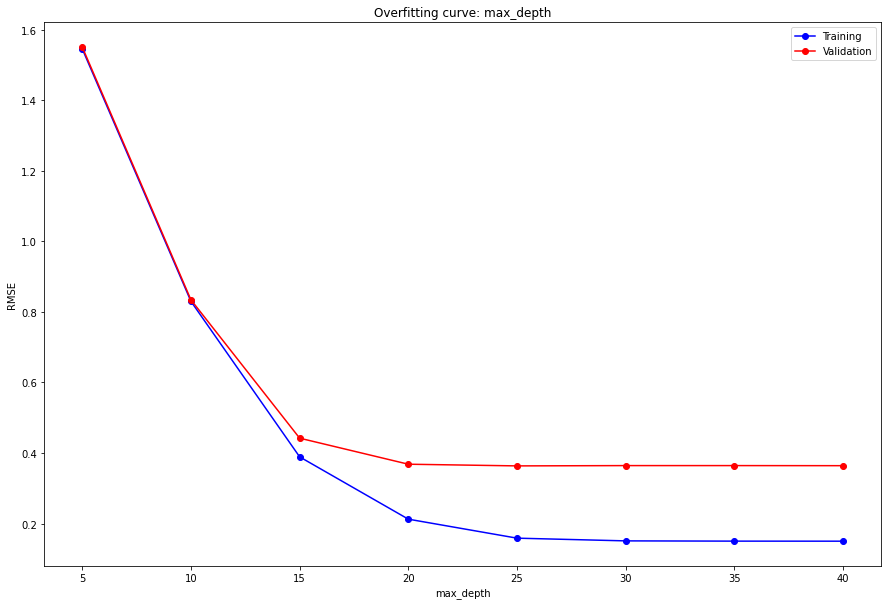

In [89]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25,30,35,40])

In [90]:
test_params(max_depth = 15)


(0.38918830532852294, 0.44217459991676783)

Training the Best Model


In [91]:
rf2 = RandomForestRegressor(n_estimators=15, random_state = 0, min_samples_leaf = 1)


In [92]:
rf2.fit(train_inputs, train_targets)


RandomForestRegressor(n_estimators=15, random_state=0)

In [93]:
rf2_train_preds = rf2.predict(train_inputs)
rf2_train_rmse = mean_squared_error(train_targets, rf2_train_preds, squared=False)
rf2_val_preds = rf2.predict(val_inputs)
rf2_val_rmse = mean_squared_error(val_targets, rf2_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))


Train RMSE: 0.15017254032448948, Validation RMSE: 0.36463695444271516


Random Forest Feature Importance


In [94]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

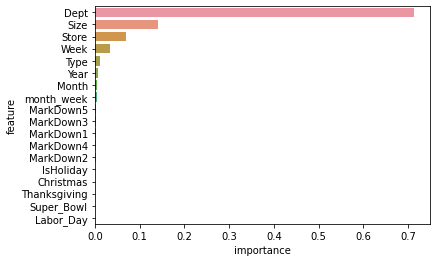

In [95]:
sns.barplot(data=rf2_importance_df, x='importance', y='feature')


Making Predictions on the Test Set


In [96]:
# df_all_test_target = df_all[(df_all["Weekly_Sales"].isnull())]["Weekly_Sales"]
# df_all_test=df_all[(df_all["Weekly_Sales"].isnull())].drop("Weekly_Sales",axis=1)
df_all_test_target = df_all[(df_all["Weekly_Sales_log"].isnull())]["Weekly_Sales_log"]
df_all_test=df_all[(df_all["Weekly_Sales_log"].isnull())].drop("Weekly_Sales_log",axis=1)

In [97]:
# df_all_test["Weekly_Sales_1year_before"]=df_all_test["Weekly_Sales_1year_before"].fillna(0)

In [98]:
test_preds = rf2.predict(df_all_test)

submit

In [99]:
#提出ようデータにデータを追加
sample_submission['Weekly_Sales'] = np.expm1(test_preds)
sample_submission.to_csv('submission.csv', index=False)


In [100]:
sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,28406.276320
1,1_1_2012-11-09,19451.197621
2,1_1_2012-11-16,19450.992595
3,1_1_2012-11-23,19231.441265
4,1_1_2012-11-30,21256.411465
...,...,...
115059,45_98_2013-06-28,673.269102
115060,45_98_2013-07-05,695.534004
115061,45_98_2013-07-12,639.174258
115062,45_98_2013-07-19,732.083708


In [101]:
#予測したデータを元のデータに追加
test=all_data[all_data["Weekly_Sales"].isnull()]
test["Weekly_Sales"]= np.expm1(test_preds)
train=all_data[~(all_data["Weekly_Sales"].isnull())]
all_data=pd.concat([train,test])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


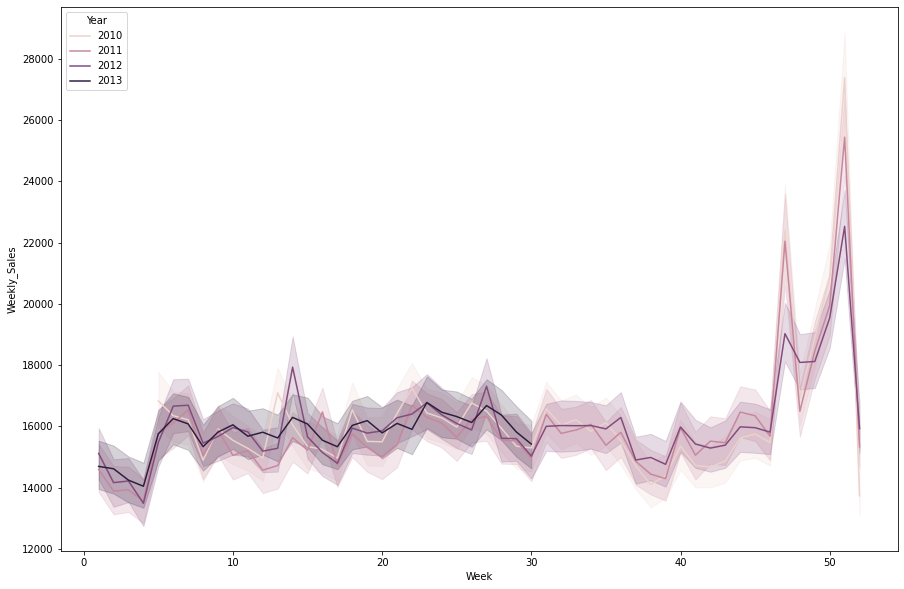

In [102]:
#週別週間売上（年ごと）
plt.figure(figsize=(15,10))
sns.lineplot(data=all_data,x='Week',y='Weekly_Sales',hue='Year',linewidth=1.5)
plt.show()